## Test 3 assumptions in methods

Imports

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Assumption 1

Assumption 1 states that $P(R|H)$ is independent of network weights $W$. 

We demonstrate that is the case here by plotting a heatmap of reward densities as a function of one of the network weights. 

In [3]:
c = 0.5

nsims = 1
N = 19
#fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_counterfactual_simulations.npz'%(N, nsims, c)

sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
us = sims['us']
wvals = sims['wvals']

In [4]:
DeltaT = 50
tau_s = 0.2
p = 0.2
wmax = 20
wmin = 2

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

B1 = 1
B2 = 2
x = .01
y = 0.1
z = 0
cost2_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

cost2_w1 = np.zeros((N,N,hs.shape[4]))
hs2_w1 = np.zeros((N,N,2,hs.shape[4]))

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost2_w1[i,j,:] = cost2_fun(s1, s2)
            hs2_w1[i,j,:,:] = hs[i,j,k,:,:]

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18


In [5]:
#Take last of cost2 in each bin
cost_r = cost2_w1.reshape((N, N, -1, DeltaT))
cost = np.squeeze(cost_r[:,:,:,-1])
cost.shape

hs_r = hs2_w1.reshape((N, N, 2, -1, DeltaT))
hs_bin = np.max(hs_r,4)
hs_bin.shape

#Total spikes
hs_r = hs2_w1.reshape((N, N, 2, -1, DeltaT))
hs_sum = np.sum(hs_r,4)


#Find bins for each firing pattern (0,0), (0,1), (1,0), (1,1)
h0_0_h1_0 = np.multiply(hs_bin[:,:,0,:] == 0, hs_bin[:,:,1,:] == 0)
h0_0_h1_1 = np.multiply(hs_bin[:,:,0,:] == 0, hs_bin[:,:,1,:] == 1)
h0_1_h1_0 = np.multiply(hs_bin[:,:,0,:] == 1, hs_bin[:,:,1,:] == 0)
h0_1_h1_1 = np.multiply(hs_bin[:,:,0,:] == 1, hs_bin[:,:,1,:] == 1)

In [154]:
hs_sum.shape

(19, 19, 2, 10000)

In [6]:
#Make histogram for each weight
M = 30

hist00 = np.zeros((N, N, M))
hist01 = np.zeros((N, N, M))
hist10 = np.zeros((N, N, M))
hist11 = np.zeros((N, N, M))

rng = (0, 1e-4)

for i in range(N):
    for j in range(N):
        hist00[i,j,:] = np.histogram(cost[i,j,h0_0_h1_0[i,j,:]], M, rng, density = True)[0]
        hist01[i,j,:] = np.histogram(cost[i,j,h0_0_h1_1[i,j,:]], M, rng, density = True)[0]
        hist10[i,j,:] = np.histogram(cost[i,j,h0_1_h1_0[i,j,:]], M, rng, density = True)[0]
        hist11[i,j,:] = np.histogram(cost[i,j,h0_1_h1_1[i,j,:]], M, rng, density = True)[0]

/opt/anaconda/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


TypeError: Invalid dimensions for image data

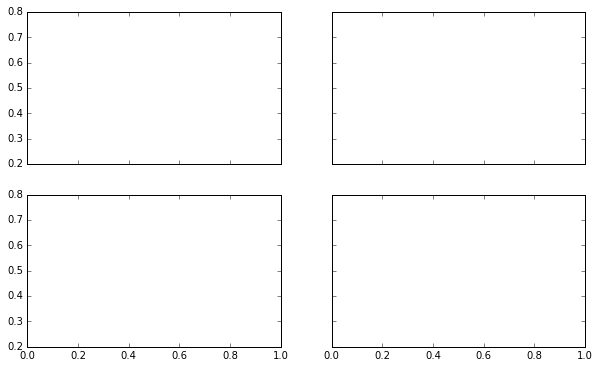

In [7]:
fig, axes = plt.subplots(2,2,sharex = True, sharey=True)
axes[0,0].imshow(hist00.T, interpolation = 'none', origin = 'lower')
axes[0,1].imshow(hist01.T, interpolation = 'none', origin = 'lower')
axes[1,0].imshow(hist10.T, interpolation = 'none', origin = 'lower')
axes[1,0].set_xlabel('W')
axes[1,1].imshow(hist11.T, interpolation = 'none', origin = 'lower')
axes[1,1].set_xlabel('W')
hist11.shape

In [8]:
#Take the mean of each of these...
mean00 = np.zeros((N,N))
mean01 = np.zeros((N,N))
mean10 = np.zeros((N,N))
mean11 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        mean00[i,j] = np.mean(cost[i,j,h0_0_h1_0[i,j,:]])
        mean01[i,j] = np.mean(cost[i,j,h0_0_h1_1[i,j,:]])
        mean10[i,j] = np.mean(cost[i,j,h0_1_h1_0[i,j,:]])
        mean11[i,j] = np.mean(cost[i,j,h0_1_h1_1[i,j,:]])
        
grad00 = np.gradient(mean00)
grad01 = np.gradient(mean01)
grad10 = np.gradient(mean10)
grad11 = np.gradient(mean11)

absgrad00 = np.sqrt(grad00[0]**2 + grad00[1]**2)#/mean00
absgrad01 = np.sqrt(grad01[0]**2 + grad01[1]**2)#/mean01
absgrad10 = np.sqrt(grad10[0]**2 + grad10[1]**2)#/mean10
absgrad11 = np.sqrt(grad11[0]**2 + grad11[1]**2)#/mean11

In [148]:
absgrad00.shape

(19, 19)

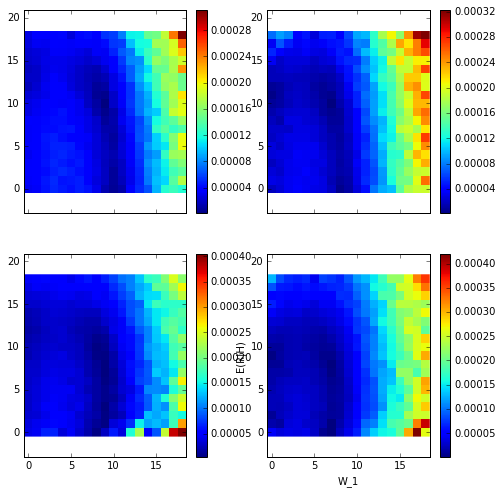

In [9]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharex = True)
a1 = axes[0,0].imshow(absgrad00, interpolation = 'none', origin = 'lower')
a2 = axes[0,1].imshow(absgrad01, interpolation = 'none', origin = 'lower')
a3 = axes[1,0].imshow(absgrad10, interpolation = 'none', origin = 'lower')
a4 = axes[1,1].imshow(absgrad11, interpolation = 'none', origin = 'lower')
plt.colorbar(a1, ax = axes[0,0])
plt.colorbar(a2, ax = axes[0,1])
plt.colorbar(a3, ax = axes[1,0])
plt.colorbar(a4, ax = axes[1,1])
plt.xlabel('W_1')
plt.ylabel('E(R|H)')
plt.savefig('S1_assumption_1a.eps')

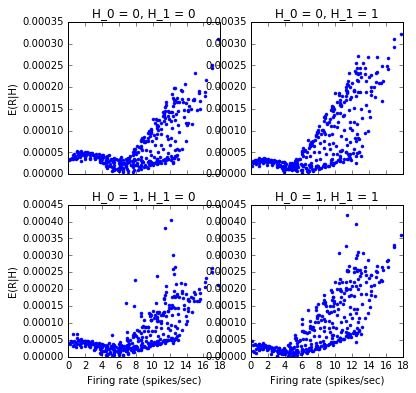

In [15]:
#Plot relative gradients as a function of firing rate
hs_sum.shape
mean_hs = np.mean(hs_sum, 3)
mean_hs_comb = np.sqrt(mean_hs[:,:,0]**2 + mean_hs[:,:,1]**2)
#Convert to spikes/sec
mean_hs_comb = mean_hs_comb/(0.002*DeltaT)
#plt.imshow(mean_hs_comb, interpolation = 'none', origin = 'lower')
fig, axes = plt.subplots(2,2, figsize = (6,6), sharex = True)
axes[0,0].plot(mean_hs_comb.reshape(-1,1), absgrad00.reshape(-1, 1), '.')
axes[0,1].plot(mean_hs_comb.reshape(-1,1), absgrad01.reshape(-1, 1), '.')
axes[1,0].plot(mean_hs_comb.reshape(-1,1), absgrad10.reshape(-1, 1), '.')
axes[1,1].plot(mean_hs_comb.reshape(-1,1), absgrad11.reshape(-1, 1), '.')
axes[1,1].set_xlabel('Firing rate (spikes/sec)')
axes[1,0].set_xlabel('Firing rate (spikes/sec)')
axes[1,0].set_ylabel('E(R|H)')
axes[0,0].set_ylabel('E(R|H)')
axes[0,0].set_title('H_0 = 0, H_1 = 0')
axes[0,1].set_title('H_0 = 0, H_1 = 1')
axes[1,0].set_title('H_0 = 1, H_1 = 0')
axes[1,1].set_title('H_0 = 1, H_1 = 1')
#sns.despine(trim = True)
plt.savefig('S1_assumption_1b.eps')

Looks like the assumption doesn't hold for the density in general. In fact........ if it did, we would expect these to be flat as a function of $W$

However, perhaps an argument can be made that these assumptions _do_ hold at bins where one of the units is near threshold.

Further, the assumption does appear to hold for the expected values. Which is actually all we need. It holds, at least, for lower firing rate. This also, is as we would expect. Good to have a visual of when the assumption breaks down...

## Assumption 2

Here we test the assumption that $\frac{\partial}{\partial w}E(H_0|H_1)$ is independent of $H_1$. That is, we check if the gradient of each $\frac{\partial}{\partial w}E(H_0|H_1=i)$ are roughly equal, for $i = 0,1$. 

We just make a heatmap of each to see...

In [16]:
DeltaT = 50
tau_s = 0.2
p = 0.2
wmax = 20
wmin = 2

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

B1 = 1
B2 = 2
x = .01
y = 0.1
z = 0
cost2_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

cost2_w12 = np.zeros((N,N,hs.shape[4]))
hs12 = np.zeros((N,N,2,hs.shape[4]))

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost2_w12[i,j,:] = cost2_fun(s1, s2)
            hs12[i,j,:,:] = hs[i,j,k,:,:]

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18


In [42]:
#Total spikes
hs_r = hs12.reshape((N, N, 2, -1, DeltaT))
hs_sum = np.sum(hs_r,4)

h0_h1_0 = hs_sum[:,:,1,:] == 0
h0_h1_1 = hs_sum[:,:,1,:] == 1

In [47]:
hs_sum[i,j,0,h0_h1_0[i,j,:]].shape

(9957,)

In [48]:
mean0 = np.zeros((N,N))
mean1 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        mean0[i,j] = np.mean(hs_sum[i,j,0,h0_h1_0[i,j,:]])
        mean1[i,j] = np.mean(hs_sum[i,j,0,h0_h1_1[i,j,:]])

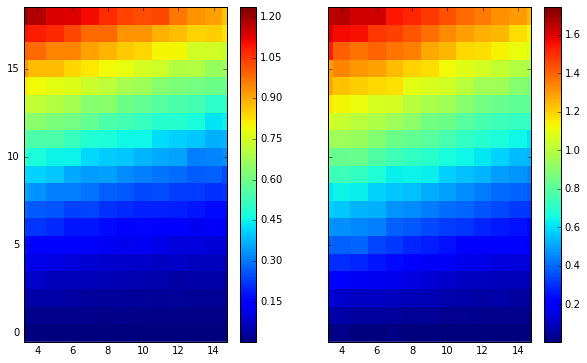

In [49]:
fig, axes = plt.subplots(1,2, sharey = True)
im1 = axes[0].imshow(mean0, interpolation = 'none', origin = 'lower')
im2 = axes[1].imshow(mean1, interpolation = 'none', origin = 'lower')
plt.colorbar(im1, ax = axes[0])
plt.colorbar(im2)

Thus assumption 2 is easily satisified.

In [36]:
grad_h0h10 = np.gradient(mean0)
grad_h0h11 = np.gradient(mean1)

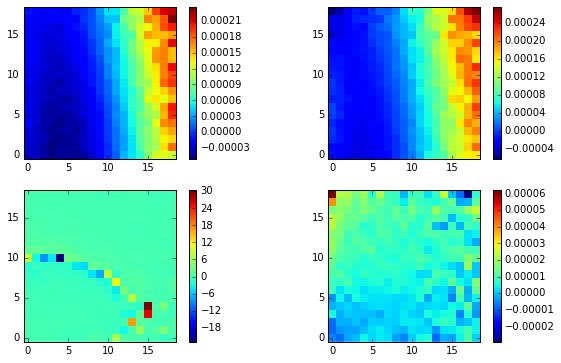

In [67]:
fig, axes = plt.subplots(2,2)
a1 = axes[0,0].imshow(grad_h0h10[1], interpolation = 'none', origin = 'lower')
a2 = axes[0,1].imshow(grad_h0h11[1], interpolation = 'none', origin = 'lower')

#a3 = axes[1,0].imshow(grad_h0h10[0], interpolation = 'none', origin = 'lower')
#a4 = axes[1,1].imshow(grad_h0h11[0], interpolation = 'none', origin = 'lower')

#a3 = axes[1,0].imshow((grad_h0h11[1]-grad_h0h10[1])/grad_h0h11[1], interpolation = 'none', origin = 'lower')
#a4 = axes[1,1].imshow((grad_h0h11[1]-grad_h0h10[1]), interpolation = 'none', origin = 'lower')

a3 = axes[1,0].imshow((grad_h0h11[0]-grad_h0h10[0])/grad_h0h11[0], interpolation = 'none', origin = 'lower')
a4 = axes[1,1].imshow((grad_h0h11[0]-grad_h0h10[0]), interpolation = 'none', origin = 'lower')

#plt.imshow(grad_h0h10[1], interpolation = 'none', origin = 'lower')
plt.colorbar(a1, ax = axes[0,0])
plt.colorbar(a2, ax = axes[0,1])
plt.colorbar(a3, ax = axes[1,0])
plt.colorbar(a4, ax = axes[1,1])

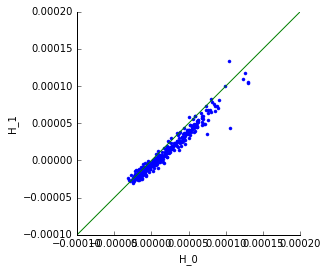

In [77]:
fig, ax = plt.subplots(1,1, figsize = (4,4))
#a4 = ax[0].imshow((grad_h0h11[0]-grad_h0h10[0]), interpolation = 'none', origin = 'lower')
#ax[0].set_xlabel('W_0')
#ax[0].set_ylabel('W_1')
#plt.colorbar(a4, ax = ax[0])
ax.plot(grad_h0h11[0].reshape(-1,1),grad_h0h10[0].reshape(-1,1), '.')
ax.plot([-0.0001, 0.0002],[-0.0001, 0.0002])
ax.set_xlabel('H_0')
sns.despine(trim = True)
ax.set_ylabel('H_1')
plt.savefig('./S1_assumption_2.eps')

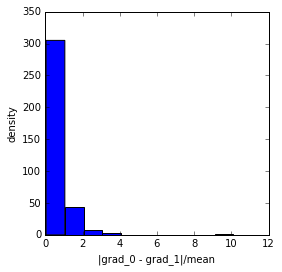

In [38]:
fig, axes = plt.subplots(1,1, figsize = (4,4))
axes.hist((absdiffgrad/absgrad1).reshape(-1,1))
plt.xlabel('|grad_0 - grad_1|/mean')
plt.ylabel('density')
#plt.savefig('./S1_assumption_2.eps')

## Assumption 3

Test that nodes $H_1$ satisfies backdoor criterion with respect to $H_0 \to R$.

Not sure what easiest way to do this is, yet.